# Ising model using VQE

Import packages:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA # optimizers
from qiskit.circuit.library import EfficientSU2 # ansatz
from qiskit.opflow import X, Z, I # operators

Defining new LaTeX commands for bra and ket vectors...
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

## Transverse field Ising model (TFIM) - setup

Here we try to find the ground state energy of TFIM using VQE. The TIFM is given by the Hamiltonian: $$H = -J \sum_{<ij>} Z_i Z_j - h \sum_i X_i.$$
This would give us a degenerate ground state for $h = 0$ (all spins up or all spins down). To avoid this, we break degeneracy by introducing a small magnetic field in the z-direction, $h_z$, by adding to the Hamiltonian the term: $$-h_z \sum_i Z_i.$$ We require that $h_z \ll h$, by a few orders of magnitude.

### Ansatz and hamiltonian

First, we create an ansatz for our calculation from Ry, Rz and CNOT gates. The depth (number of layers) is set to 2 in order to reduce the number of parameters that need to be optimised by a classical optimiser. In this case, we have 24 free parameters.

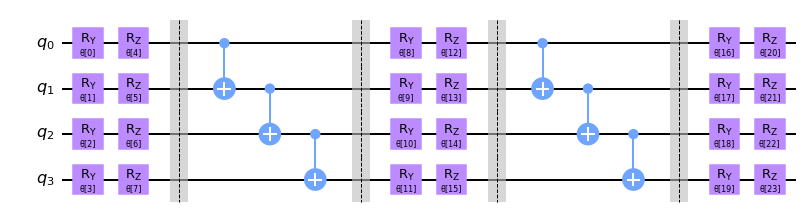

In [2]:
NUM_QUBITS = 4
ansatz = EfficientSU2(NUM_QUBITS, entanglement='linear',
                      insert_barriers=True, su2_gates=['ry', 'rz'], reps=2)
display(ansatz.decompose().draw('mpl'))

Here we define the Ising Hamiltonian operator for n qubits. The $h$ and $J$ parameters correspond to the strength of transverse magnetic field and the coupling constant, respectively.

In [3]:
def ising_hamiltonian(n_qubits, h, h_z=0., J=1.):
    first_term_operators = np.full(n_qubits, I)
    second_term_operators = np.full(n_qubits, I)
    third_term_operators = np.full(n_qubits, I)
    
    first_term_operators[0] = X
    second_term_operators[0] = Z
    second_term_operators[1] = Z
    third_term_operators[0] = Z
    
    first_term = reduce(lambda x, y: x.tensor(y), first_term_operators)
    second_term = reduce(lambda x, y: x.tensor(y), second_term_operators)
    third_term = reduce(lambda x, y: x.tensor(y), third_term_operators)
    
    for i in range(n_qubits-1):
        first_term_operators = np.roll(first_term_operators, 1)
        first_term += reduce(lambda x, y: x.tensor(y), first_term_operators)
        
        second_term_operators = np.roll(second_term_operators, 1)
        second_term += reduce(lambda x, y: x.tensor(y), second_term_operators)
        
        third_term_operators = np.roll(third_term_operators, 1)
        third_term += reduce(lambda x, y: x.tensor(y), third_term_operators)
        
    hamiltonian = - h * first_term - J * second_term - h_z * third_term

    #Four-qubit case should look like this:
    #hamiltonian = - (h * ((X^I^I^I) + (I^X^I^I) + (I^I^X^I) + (I^I^I^X))
    #                + J * ((I^I^Z^Z) + (I^Z^Z^I) + (Z^Z^I^I) + (Z^I^I^Z))
    #                + h_z * ((Z^I^I^I) + (I^Z^I^I) + (I^I^Z^I) + (I^I^I^Z)))
    
    return hamiltonian

NOTES: the Ising Hamiltonian is a Hermitian matrix (good), but it is not unitary (bad?). Its determinant, depending on the fields, is in many cases equal to 0, so it is not invertible.


### Ground state energy and eigenvector functions

Find the exact diagonalisation using NumPy function that finds the eigenvalues and eigenvectors of a given matrix:

In [4]:
def find_exact_solution(hamiltonian_matrix):
    num_qubits = int(np.sqrt(hamiltonian_matrix.shape[0]))
    e_values, e_vectors = np.linalg.eigh(hamiltonian_matrix)
    e_values /= num_qubits
    e_vectors = e_vectors
    return e_values[0], e_vectors[:, 0]

The function below plots the probabilities of different basis states obtained from both VQE and exact diagonalisation, to let us compare them visually:

In [5]:
def plot_state_probabilities(exact_state, vqe_state, h_field):
    # Generate strings representing the computational basis states
    basis_states = [str(bin(x)[2:]) for x in range(2**NUM_QUBITS)]
    basis_states = [x.rjust(4, '0') for x in basis_states]
    
    # Create a figure and plot probabilities
    fig, ax = plt.subplots(figsize=(6, 3))
    x_values = np.arange(2 ** NUM_QUBITS)
    ax.scatter(x_values, abs(exact_state)**2, label="Exact", s=35)
    ax.scatter(x_values, abs(vqe_state)**2, label="VQE", s=35)
    ax.set_ylim(-0.05, 1.05)
    
    # Add some information to the plot
    ax.set_title("h = {0:.3f}".format(h_field), fontsize=14)
    ax.set_xlabel("Computational basis state", fontsize=14)
    ax.set_ylabel("Probability", fontsize=14)
    ax.set_xticks(x_values)
    ax.set_xticklabels(basis_states, rotation=50, fontsize=12)
    ax.legend(fontsize=12, loc='best')
    
    return fig

In [6]:
def fill_missing_states(statevector):
    num_qubits = len(list(statevector.keys())[0])
    # Generate strings representing the computational basis states
    basis_states = [str(bin(x)[2:]) for x in range(2**num_qubits)]
    basis_states = [x.rjust(4, '0') for x in basis_states]
    
    for state in basis_states:
        if state not in statevector.keys():
            statevector[state] = 0.
    
    # Sort the satetvector dictionary by its keys
    sorted_statevector = {key: statevector[key] for key in sorted(statevector)}
    
    return sorted_statevector

### Fidelity and magentisation functions

This function computes the fidelity between VQE final state and the exact eigenstate:

In [7]:
def fidelity(exact_state, vqe_state):
    fidelity = np.abs(np.dot(exact_state, vqe_state))**2
    return fidelity

This function creates a list of fidelities given lists of exact and VQE states:

In [8]:
def compute_fidelities(exact_eigvect_list, vqe_eigvect_list):
    fidelity_list = []
    for (exact_state, vqe_state) in zip(exact_eigvect_list, vqe_eigvect_list):
        fid = fidelity(exact_state, vqe_state)
        fidelity_list.append(fid)
    return fidelity_list

Here we define the magnetisation operators:

In [9]:
def magnetisation_operator(n_qubits, axis):
    terms = np.full(n_qubits, I)
    if axis == 'x':
        terms[0] = X
    elif axis =='z':
        terms[0] = Z
    else:
        print("Invalid argument. Axis must be 'x' or 'y'!")
        return None
    
    operator = reduce(lambda x, y: x.tensor(y), terms)
    
    for i in range(n_qubits-1):
        terms = np.roll(terms, 1)
        operator += reduce(lambda x, y: x.tensor(y), terms)
    
    return operator

x_magnetisation_op = magnetisation_operator(NUM_QUBITS, 'x')
z_magnetisation_op = magnetisation_operator(NUM_QUBITS, 'z')

Now we compute the magnetisation for the exact case. Note that we return the value normalised by the number of qubits.

In [10]:
def exact_magnetisation(magnetisation_operator, eigenvector):
    matrix = magnetisation_operator.to_matrix()
    product = matrix.dot(eigenvector)
    magnetisation = np.vdot(eigenvector, product).real
    return magnetisation / NUM_QUBITS

This is a function that prints all the important results in a nice form:

In [11]:
def print_all_results(results):
    np.set_printoptions(precision=3)
    
    for (h, energy, eigvect, mag, vqe_energy, vqe_eigvect, vqe_mag, fidelity) in results:
        print("\n==================== h = {0:.3f} ====================".format(h))
        
        print("Ground state ENERGY per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(energy, vqe_energy))
        print("MAGNETISATION per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(mag, vqe_mag))
        print("FIDELITY: {0:.3f}".format(fidelity))
        
        print("\nGround state EIGENVECTOR:\n\tExact: {0}\n\tVQE: {1}".format(eigvect.real, vqe_eigvect.real))
        fig = plot_state_probabilities(eigvect, vqe_eigvect, h)
        display(fig)
        plt.close()

    return

## TFIM on a real device

Finally, we will submit a job to a real IBMQ device:

In [12]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.utils.mitigation import CompleteMeasFitter
from qiskit_ibm_runtime import QiskitRuntimeService

In [13]:
h_list = (10 ** np.linspace(-1.5, 1.5, 7)).tolist()
h_list.append(1.5)
h_list.append(1.25)
h_list.append(0.75)
h_list.append(2.0)
h_list.sort()

h_bias = 0.1

In [14]:
print(h_list)

[0.03162277660168379, 0.1, 0.31622776601683794, 0.75, 1.0, 1.25, 1.5, 2.0, 3.1622776601683795, 10.0, 31.622776601683793]


Here we perform the exact calculation for these field values and then plot the energy and magnetisations:

In [15]:
exact_magnetisation_z_list = []
exact_magnetisation_x_list = []
exact_energy_list = []
exact_eigenvector_list = []

for h in h_list:
    print("Computing for h = {0:.3f}".format(h))
    hamiltonian = ising_hamiltonian(NUM_QUBITS, h, h_z=h_bias)
    exact_energy, exact_eigenvector = find_exact_solution(hamiltonian.to_matrix())
    exact_eigenvector_list.append(exact_eigenvector)
    exact_energy_list.append(exact_energy)
    exact_magnetisation_z_list.append(exact_magnetisation(z_magnetisation_op, exact_eigenvector))
    exact_magnetisation_x_list.append(exact_magnetisation(x_magnetisation_op, exact_eigenvector))
    
print("DONE!")

Computing for h = 0.032
Computing for h = 0.100
Computing for h = 0.316
Computing for h = 0.750
Computing for h = 1.000
Computing for h = 1.250
Computing for h = 1.500
Computing for h = 2.000
Computing for h = 3.162
Computing for h = 10.000
Computing for h = 31.623
DONE!


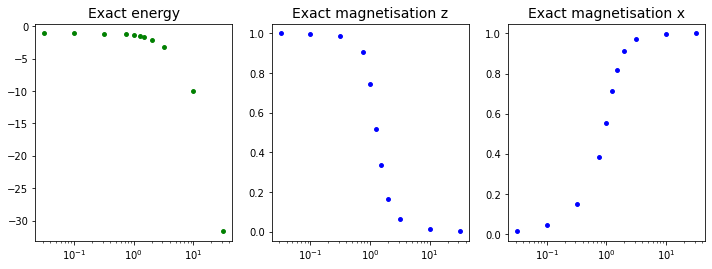

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].scatter(h_list, exact_energy_list, s=15, c='g')
axes[0].set_title("Exact energy", fontsize=14)
axes[0].set_xscale('log')
axes[1].scatter(h_list, exact_magnetisation_z_list, s=15, c='b')
axes[1].set_title("Exact magnetisation z", fontsize=14)
axes[1].set_xscale('log')
axes[2].scatter(h_list, exact_magnetisation_x_list, s=15, c='b')
axes[2].set_title("Exact magnetisation x", fontsize=14)
axes[2].set_xscale('log')

In [17]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

**Table of job IDs for different fields:**
| h_field | job_id | iterations |
| :-----: | :----: | :--------: |
| 0.03162277660168379 | cbtp6vllktk3613s71k0 | 10 |

In [23]:
jobs_list_100iter = ['cbucvellktk3613u1lpg', 'cbugs30lvap7pf91i6f0', 'cbugs3dlktk3613ud5g0', 'cbugs3j1uoq3f11ao1d0', 'cbugs3olvap7pf91i6jg', 'cbugs3tlktk3613ud5k0', 'cbugs431uoq3f11ao1fg', 'cbugs48lvap7pf91i6m0', 'cbugs4dlktk3613ud5ng', 'cbugs4j1uoq3f11ao1i0', 'cbugs4j1uoq3f11ao1j0']
jobs_list_1000iter = ['cc1lmbj1uoq3f11jlkug', 'cc1lmbv6q7nnhokan7h0', 'cc1lmc31uoq3f11jll20', 'cc1lmc31uoq3f11jll30', 'cc1lmcf6q7nnhokan7kg', 'cc1lmc8lvap7pf9agan0', 'cc1lmcglvap7pf9agao0', 'cc1lmcv6q7nnhokan7n0', 'cc1lmcr1uoq3f11jll90', 'cc1lmd31uoq3f11jlla0', 'cc1lmd76q7nnhokan7pg']

In [24]:
vqe_magnetisation_z_list = []
vqe_magnetisation_x_list = []
vqe_energy_list = []
vqe_eigenvector_list = []
fidelity_list = []

In [25]:
for job_id in jobs_list_1000iter:
    job = provider.runtime.job(job_id)
    result = job.result()
    vqe_energy_list.append(result['optimal_value'] / NUM_QUBITS)
    eigenvector = result['eigenstate']
    eigenvector_full = fill_missing_states(eigenvector).values()
    vqe_eigenvector_list.append(np.array(list(eigenvector_full)))
    vqe_magnetisation_x_list.append(result['aux_operator_eigenvalues']['x_mag'][0] / NUM_QUBITS)
    vqe_magnetisation_z_list.append(result['aux_operator_eigenvalues']['z_mag'][0] / NUM_QUBITS)


==================== h = 0.032 ====================
Ground state ENERGY per qubit:
	Exact: -1.100
	VQE: -0.963
MAGNETISATION per qubit in z:
	Exact: 1.000
	VQE: 0.854
MAGNETISATION per qubit in x:
	Exact: 0.015
	VQE: 0.007
FIDELITY: 0.878

Ground state EIGENVECTOR:
	Exact: [-9.99886603e-01 -7.52872797e-03 -7.52872797e-03 -1.08221444e-04
 -7.52872797e-03 -5.66932653e-05 -1.08221444e-04 -1.87933024e-06
 -7.52872797e-03 -1.08221444e-04 -5.66932653e-05 -1.87933024e-06
 -1.08221444e-04 -1.87933024e-06 -1.87933024e-06 -2.96794857e-07]
	VQE: [0.93436977 0.03125    0.08838835 0.03125    0.0625     0.03125
 0.11267348 0.         0.16535946 0.         0.12103073 0.03125
 0.15309311 0.04419417 0.16237976 0.0625    ]


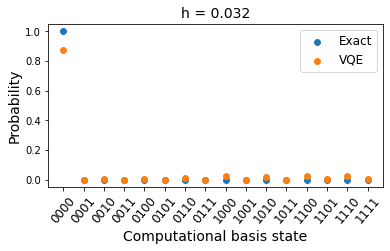


==================== h = 0.100 ====================
Ground state ENERGY per qubit:
	Exact: -1.102
	VQE: -0.912
MAGNETISATION per qubit in z:
	Exact: 0.999
	VQE: 0.847
MAGNETISATION per qubit in x:
	Exact: 0.048
	VQE: 0.040
FIDELITY: 0.810

Ground state EIGENVECTOR:
	Exact: [-9.98864420e-01 -2.37935338e-02 -2.37935338e-02 -1.08190371e-03
 -2.37935338e-02 -5.67295197e-04 -1.08190371e-03 -5.98910682e-05
 -2.37935338e-02 -1.08190371e-03 -5.67295197e-04 -5.98910682e-05
 -1.08190371e-03 -5.98910682e-05 -5.98910682e-05 -2.95930720e-05]
	VQE: [0.88939059 0.         0.08267973 0.05412659 0.08838835 0.04419417
 0.07654655 0.08838835 0.30136409 0.         0.11267348 0.
 0.21875    0.06987712 0.10364452 0.09375   ]


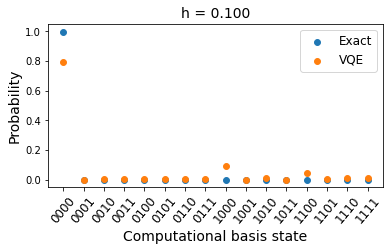


==================== h = 0.316 ====================
Ground state ENERGY per qubit:
	Exact: -1.124
	VQE: -1.007
MAGNETISATION per qubit in z:
	Exact: 0.988
	VQE: 0.891
MAGNETISATION per qubit in x:
	Exact: 0.152
	VQE: 0.068
FIDELITY: 0.925

Ground state EIGENVECTOR:
	Exact: [-0.98847131 -0.07477834 -0.07477834 -0.01080598 -0.07477834 -0.00571824
 -0.01080598 -0.00203397 -0.07477834 -0.01080598 -0.00571824 -0.00203397
 -0.01080598 -0.00203397 -0.00203397 -0.00287241]
	VQE: [0.93384705 0.04419417 0.12884705 0.04419417 0.14657549 0.04419417
 0.10825318 0.04419417 0.14320549 0.         0.12884705 0.05412659
 0.08838835 0.03125    0.12884705 0.06987712]


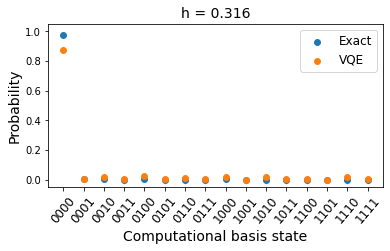


==================== h = 0.750 ====================
Ground state ENERGY per qubit:
	Exact: -1.239
	VQE: -0.984
MAGNETISATION per qubit in z:
	Exact: 0.906
	VQE: -0.165
MAGNETISATION per qubit in x:
	Exact: 0.386
	VQE: 0.338
FIDELITY: 0.463

Ground state EIGENVECTOR:
	Exact: [-0.92475565 -0.17086602 -0.17086602 -0.06202862 -0.17086602 -0.03431966
 -0.06202862 -0.03400651 -0.17086602 -0.06202862 -0.03431966 -0.03400651
 -0.06202862 -0.03400651 -0.03400651 -0.07532972]
	VQE: [0.52848545 0.14986974 0.11692679 0.14320549 0.11692679 0.0625
 0.08267973 0.16535946 0.09882118 0.0625     0.10364452 0.1875
 0.15934436 0.15625    0.21194781 0.67676274]


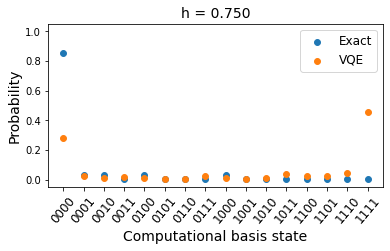


==================== h = 1.000 ====================
Ground state ENERGY per qubit:
	Exact: -1.356
	VQE: -1.218
MAGNETISATION per qubit in z:
	Exact: 0.747
	VQE: 0.760
MAGNETISATION per qubit in x:
	Exact: 0.555
	VQE: 0.470
FIDELITY: 0.950

Ground state EIGENVECTOR:
	Exact: [-0.8374991  -0.21422339 -0.21422339 -0.10926885 -0.21422339 -0.06288573
 -0.10926885 -0.0820677  -0.21422339 -0.10926885 -0.06288573 -0.0820677
 -0.10926885 -0.0820677  -0.0820677  -0.18005619]
	VQE: [0.82146496 0.21423921 0.2538762  0.10364452 0.25       0.0625
 0.11692679 0.03125    0.20963137 0.08838835 0.10825318 0.04419417
 0.22097087 0.         0.08838835 0.03125   ]


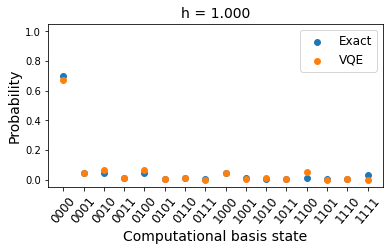


==================== h = 1.250 ====================
Ground state ENERGY per qubit:
	Exact: -1.515
	VQE: -1.234
MAGNETISATION per qubit in z:
	Exact: 0.517
	VQE: 0.551
MAGNETISATION per qubit in x:
	Exact: 0.713
	VQE: 0.689
FIDELITY: 0.917

Ground state EIGENVECTOR:
	Exact: [-0.71728748 -0.23828876 -0.23828876 -0.15370601 -0.23828876 -0.09259662
 -0.15370601 -0.13435859 -0.23828876 -0.15370601 -0.09259662 -0.13435859
 -0.15370601 -0.13435859 -0.13435859 -0.27297108]
	VQE: [0.6366109  0.26145626 0.29646353 0.15309311 0.27063294 0.125
 0.15625    0.11267348 0.28811076 0.14657549 0.22750343 0.08838835
 0.24803919 0.14986974 0.19263794 0.07654655]


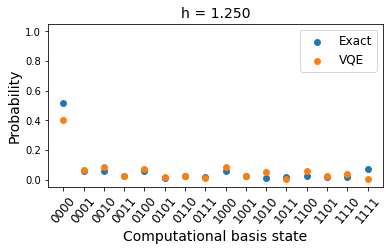


==================== h = 1.500 ====================
Ground state ENERGY per qubit:
	Exact: -1.708
	VQE: -1.500
MAGNETISATION per qubit in z:
	Exact: 0.338
	VQE: 0.581
MAGNETISATION per qubit in x:
	Exact: 0.817
	VQE: 0.668
FIDELITY: 0.913

Ground state EIGENVECTOR:
	Exact: [-0.61176629 -0.24785524 -0.24785524 -0.18394426 -0.24785524 -0.11601101
 -0.18394426 -0.17097859 -0.24785524 -0.18394426 -0.11601101 -0.17097859
 -0.18394426 -0.17097859 -0.17097859 -0.31752063]
	VQE: [0.67531821 0.27243118 0.29315098 0.14320549 0.298106   0.13621559
 0.14320549 0.07654655 0.28980058 0.11267348 0.13975425 0.07654655
 0.23385359 0.10364452 0.17399264 0.10825318]


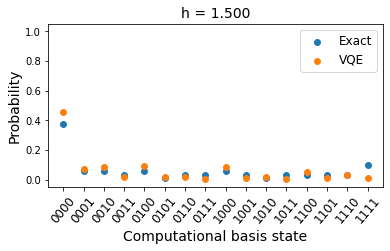


==================== h = 2.000 ====================
Ground state ENERGY per qubit:
	Exact: -2.144
	VQE: -1.794
MAGNETISATION per qubit in z:
	Exact: 0.167
	VQE: 0.032
MAGNETISATION per qubit in x:
	Exact: 0.912
	VQE: 0.856
FIDELITY: 0.921

Ground state EIGENVECTOR:
	Exact: [-0.48478858 -0.25311369 -0.25311369 -0.21453162 -0.25311369 -0.14630121
 -0.21453162 -0.20688994 -0.25311369 -0.21453162 -0.14630121 -0.20688994
 -0.21453162 -0.20688994 -0.20688994 -0.33256086]
	VQE: [0.298106   0.30777681 0.2317562  0.26516504 0.19008633 0.16237976
 0.29481191 0.2795085  0.259582   0.2440703  0.20491995 0.19008633
 0.259582   0.22316964 0.28980058 0.2400358 ]


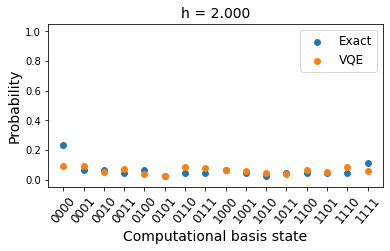


==================== h = 3.162 ====================
Ground state ENERGY per qubit:
	Exact: -3.247
	VQE: -2.856
MAGNETISATION per qubit in z:
	Exact: 0.065
	VQE: 0.088
MAGNETISATION per qubit in x:
	Exact: 0.970
	VQE: 0.842
FIDELITY: 0.965

Ground state EIGENVECTOR:
	Exact: [0.37444496 0.25428139 0.25428139 0.23656489 0.25428139 0.18086937
 0.23656489 0.2315942  0.25428139 0.23656489 0.18086937 0.2315942
 0.23656489 0.2315942  0.2315942  0.31198097]
	VQE: [0.27421764 0.26700012 0.26516504 0.29481191 0.24606275 0.26700012
 0.2538762  0.25194555 0.19764235 0.20963137 0.23385359 0.17399264
 0.25579227 0.2795085  0.23385359 0.26700012]


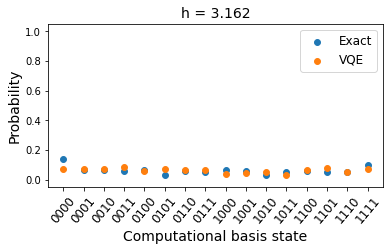


==================== h = 10.000 ====================
Ground state ENERGY per qubit:
	Exact: -10.026
	VQE: -8.404
MAGNETISATION per qubit in z:
	Exact: 0.012
	VQE: -0.000
MAGNETISATION per qubit in x:
	Exact: 0.997
	VQE: 0.818
FIDELITY: 0.979

Ground state EIGENVECTOR:
	Exact: [0.28247132 0.25212569 0.25212569 0.24871308 0.25212569 0.22615553
 0.24871308 0.24657932 0.25212569 0.24871308 0.22615553 0.24657932
 0.24871308 0.24657932 0.24657932 0.27020291]
	VQE: [0.27063294 0.26516504 0.23593233 0.24803919 0.2914806  0.27243118
 0.30297999 0.30297999 0.19515619 0.20252315 0.2317562  0.21650635
 0.22316964 0.23385359 0.259582   0.21194781]


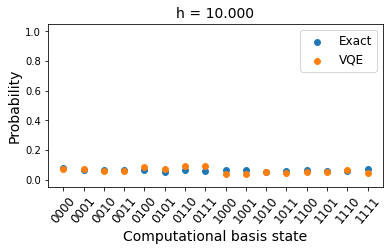


==================== h = 31.623 ====================
Ground state ENERGY per qubit:
	Exact: -31.631
	VQE: -28.940
MAGNETISATION per qubit in z:
	Exact: 0.003
	VQE: 0.006
MAGNETISATION per qubit in x:
	Exact: 1.000
	VQE: 0.916
FIDELITY: 0.988

Ground state EIGENVECTOR:
	Exact: [0.25972034 0.25075229 0.25075229 0.24987222 0.25075229 0.24221467
 0.24987222 0.2491198  0.25075229 0.24987222 0.24221467 0.2491198
 0.24987222 0.2491198  0.2491198  0.25635017]
	VQE: [0.24803919 0.22534695 0.26516504 0.2538762  0.2440703  0.2400358
 0.24803919 0.27599253 0.27243118 0.27421764 0.2795085  0.22534695
 0.21423921 0.19263794 0.23593233 0.28125   ]


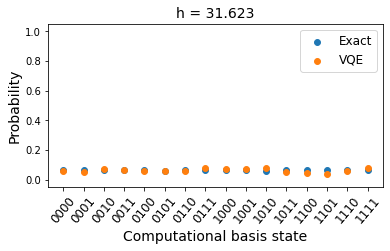

In [26]:
for i, h in enumerate(h_list):
    fid = fidelity(exact_eigenvector_list[i], vqe_eigenvector_list[i])
    fidelity_list.append(fid)
    print("\n==================== h = {0:.3f} ====================".format(h))

    print("Ground state ENERGY per qubit:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_energy_list[i], vqe_energy_list[i]))
    print("MAGNETISATION per qubit in z:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_z_list[i], vqe_magnetisation_z_list[i]))
    print("MAGNETISATION per qubit in x:\n\tExact: {0:.3f}\n\tVQE: {1:.3f}".format(exact_magnetisation_x_list[i], vqe_magnetisation_x_list[i]))
    print("FIDELITY: {0:.3f}".format(fid))

    print("\nGround state EIGENVECTOR:\n\tExact: {0}\n\tVQE: {1}".format(exact_eigenvector_list[i].real, vqe_eigenvector_list[i].real))
    fig = plot_state_probabilities(exact_eigenvector_list[i], vqe_eigenvector_list[i], h_list[i])
    display(fig)
    plt.close()

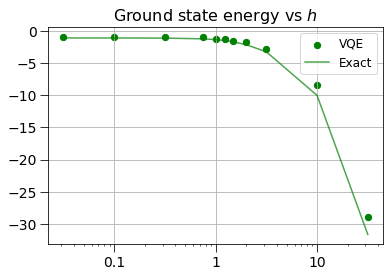

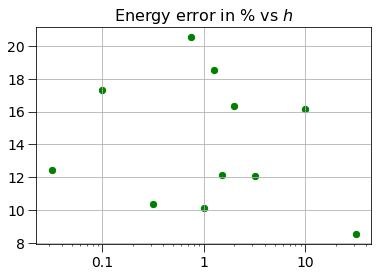

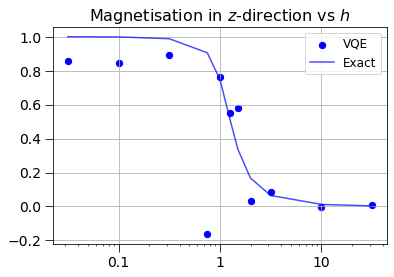

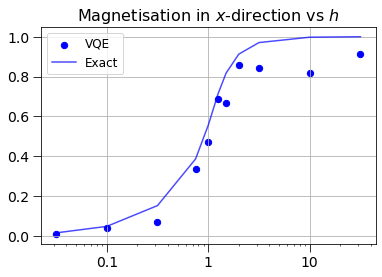

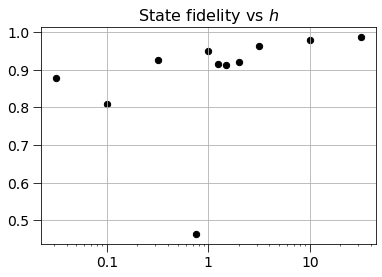

In [27]:
# Energy plot
fig_energy, ax_energy = plt.subplots(figsize=(6, 4))

ax_energy.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_energy.scatter(h_list, vqe_energy_list, s=40, c='g', label='VQE')
ax_energy.plot(h_list, exact_energy_list, c='g', alpha=0.7, label='Exact')
ax_energy.set_title("Ground state energy vs $h$", fontsize=16)
ax_energy.set_xscale('log')
ax_energy.grid(True)
ax_energy.set_xticks([0.1, 1, 10])
ax_energy.set_xticklabels([0.1, 1, 10])
ax_energy.legend(loc='best', fontsize=12);

# Energy error plot
fig_energy_diff, ax_energy_diff = plt.subplots(figsize=(6, 4))

energy_error_list = 100 * np.abs((np.array(vqe_energy_list) - np.array(exact_energy_list)) / np.array(exact_energy_list))
ax_energy_diff.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_energy_diff.scatter(h_list, energy_error_list, s=40, c='g', label='VQE')
ax_energy_diff.set_title("Energy error in % vs $h$", fontsize=16)
ax_energy_diff.set_xscale('log')
ax_energy_diff.grid(True)
ax_energy_diff.set_xticks([0.1, 1, 10])
ax_energy_diff.set_xticklabels([0.1, 1, 10]);

# Magnetisation in z plot
fig_magz, ax_magz = plt.subplots(figsize=(6, 4))

ax_magz.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_magz.scatter(h_list, vqe_magnetisation_z_list, s=40, c='b', label='VQE')
ax_magz.plot(h_list, exact_magnetisation_z_list, c='b', alpha=0.7, label='Exact')
ax_magz.set_title("Magnetisation in $z$-direction vs $h$", fontsize=16)
ax_magz.set_xscale('log')
ax_magz.grid(True)
ax_magz.set_xticks([0.1, 1, 10])
ax_magz.set_xticklabels([0.1, 1, 10])
ax_magz.legend(loc='best', fontsize=12);


# Magnetisation in x plot
fig_magx, ax_magx = plt.subplots(figsize=(6, 4))

ax_magx.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_magx.scatter(h_list, vqe_magnetisation_x_list, s=40, c='b', label='VQE')
ax_magx.plot(h_list, exact_magnetisation_x_list, c='b', alpha=0.7, label='Exact')
ax_magx.set_title("Magnetisation in $x$-direction vs $h$", fontsize=16)
ax_magx.set_xscale('log')
ax_magx.grid(True)
ax_magx.set_xticks([0.1, 1, 10])
ax_magx.set_xticklabels([0.1, 1, 10])
ax_magx.legend(loc='best', fontsize=12);

# Fidelity plot
fig_fidel, ax_fidel = plt.subplots(figsize=(6, 4))

ax_fidel.tick_params(axis='both', which='major', labelsize=14, size=8)
ax_fidel.scatter(h_list, fidelity_list, s=40, c='k')
ax_fidel.set_title("State fidelity vs $h$", fontsize=16)
ax_fidel.set_xscale('log')
ax_fidel.grid(True)
ax_fidel.set_xticks([0.1, 1, 10])
ax_fidel.set_xticklabels([0.1, 1, 10]);

In [28]:
fig_energy.savefig("energy_1.png")
fig_energy_diff.savefig("energy_diff_1.png")
fig_magz.savefig("mag_z_1.png")
fig_magx.savefig("mag_x_1.png")
fig_fidel.savefig("fidelity_1.png")